In [1]:
# import tensorflow as tf
import numpy as np
import os
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import io
from PIL import Image, ImageDraw
from io import BytesIO
import cv2
import math
%matplotlib inline

In [2]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]

In [3]:
def skeleton_image(joints_2d, img):
    img_copy = img.copy()
#     colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
#           (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (50, 255, 100), (50, 50, 0)]
    
    colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
          (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (175,100,195), (255,125,25)]
    joints_2d = joints_2d
    for i in range(joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        img_copy = cv2.line(img_copy, (int(x_pair[0]),int(y_pair[0])), (int(x_pair[1]),int(y_pair[1])), colors[i],4)

    return img_copy[:,:,::-1]

In [4]:
def get_gaussian_maps(mu, shape_hw, inv_std, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.linspace(-1.0, 1.0, shape_hw[0])

    x = np.linspace(-1.0, 1.0, shape_hw[1])

    if mode in ['rot', 'flat']:
        mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)

        y = np.reshape(y, [1, 1, shape_hw[0], 1])
        x = np.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = np.square(y - mu_y)
        g_x = np.square(x - mu_x)
        dist = (g_y + g_x) * inv_std**2
        dist1 = (g_y + g_x) * (inv_std*4)**2

        if mode == 'rot':
            g_yx = np.exp(-dist)
            g_yx1 = np.exp(-dist1)
        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    elif mode == 'ankush':
        y = np.reshape(y, [1, 1, shape_hw[0]])
        x = np.reshape(x, [1, 1, shape_hw[1]])

        g_y = np.exp(-np.sqrt(1e-4 + np.abs((mu_y - y) * inv_std)))
        g_x = np.exp(-np.sqrt(1e-4 + np.abs((mu_x - x) * inv_std)))

        g_y = np.expand_dims(g_y, axis=3)
        g_x = np.expand_dims(g_x, axis=2)
        g_yx = np.matmul(g_y, g_x)  # [B, NMAPS, H, W]

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    g_yx = np.transpose(g_yx, axes=[0, 2, 3, 1])
    g_yx1 = np.transpose(g_yx1, axes=[0, 2, 3, 1])
    return g_yx, g_yx1

In [5]:
def get_rot_gaussian_maps_(mu, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, 0:1], mu[:, 1:2]     # (17, 1)

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))

    
    y = []
    x = []
    for i in range(shape_hw[0]):
        y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
        x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.stack(y, 0)
    x = np.stack(x, 0).T
    y = np.expand_dims(y, 0)
    x = np.expand_dims(x, 0)
    for i in range(mu.shape[0]-1):
        y = np.concatenate([y, y[0:1]],0)
        x = np.concatenate([x, x[0:1]],0)
    
    mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)
    
    y = y - mu_y
    x = x - mu_x
    print (y.shape)
    print (x.shape)
    
    if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
        # *0.+math.pi/2
        yx_stacked = np.stack([y.reshape((mu.shape[0],-1)), x.reshape((mu.shape[0],-1))], 1)   # (17, 2, 196)
        rot_mat = np.stack([ np.stack([np.cos(angles), np.sin(angles)],1), 
                             np.stack([-np.sin(angles), np.cos(angles)],1) ], 2)   # (17, 2, 2)

        rotated = np.matmul(rot_mat, yx_stacked)   # (17, 2, 196)
        
        y_rot = rotated[:,0,:]   # (17, 196)
        x_rot = rotated[:,1,:]   # (17, 196)
                
        y_rot = np.reshape(y_rot, (mu.shape[0],shape_hw[0],shape_hw[0]))   # (17, 14, 14)
        x_rot = np.reshape(x_rot, (mu.shape[0],shape_hw[1],shape_hw[1]))   # (17, 14, 14)
                
                
        

#         y = np.reshape(y, [1, 1, shape_hw[0], 1])
#         x = np.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = np.square(y_rot)   # (17, 14, 14)
        g_x = np.square(x_rot)   # (17, 14, 14)
        
#         g_y[:,:,0,:] = 0.
#         g_x[:,:,:,0] = 1.
        
        

#         print (g_y[0,:,0])
#         print (g_y_rot[0,:,0])
        
#         print (g_x[0,:,0])
#         print (g_x_rot[0,:,0])
        
#         g_y_rot = np.expand_dims(g_y_rot, 3)   # (1, 17, 112, 1)
#         g_x_rot = np.expand_dims(g_x_rot, 2)   # (1, 17, 1, 112)

        inv_std1 = np.expand_dims(np.expand_dims(inv_std1, 1), 1)
        inv_std2 = np.expand_dims(np.expand_dims(inv_std2, 1), 1)
        dist = (g_y * inv_std1**2 + g_x * inv_std2**2)

        if mode == 'rot':
            g_yx = np.exp(-dist)

        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    print (g_yx.shape)
#     g_yx = np.transpose(g_yx, axes=[1, 2, 0])
    g_yx = np.transpose(g_yx, axes=[2, 1, 0])

    return g_yx#, g_yx1

In [349]:
def get_gaussian_maps_(mu, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, 0:1], mu[:, 1:2]     # (17, 1)

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))

# (112, 112)
# (112, 112)
# (1, 112, 1904)
# (1, 112, 1904)
# (17, 112, 1904)
# (17, 112, 1904)
# (17, 112, 1904)
    
#     y = list(np.linspace(-1.0, 1.0, shape_hw[0])) * shape_hw[0]
#     x = list(np.linspace(-1.0, 1.0, shape_hw[1])) * shape_hw[1]
    
#     y = np.array(y).reshape((shape_hw[0], shape_hw[0]))
#     x = np.array(x).reshape((shape_hw[1], shape_hw[1])).T
#     print (y.shape)
#     print (x.shape)
    
#     y = np.tile(y, (1, 1, mu.shape[0])) # 17,14,14
#     x = np.tile(x, (1, 1, mu.shape[0])) # 17,14,14
    
#     print (y.shape)
#     print (x.shape)
    
    
    y = []
    x = []
    for i in range(shape_hw[0]):
        y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
        x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.stack(y, 0)
    x = np.stack(x, 0).T
    y = np.expand_dims(y, 0)
    x = np.expand_dims(x, 0)
    for i in range(mu.shape[0]-1):
        y = np.concatenate([y, y[0:1]],0)
        x = np.concatenate([x, x[0:1]],0)
#     y = np.linspace(-1.0, 1.0, shape_hw[0])
#     x = np.linspace(-1.0, 1.0, shape_hw[1])

    print (x.shape)
    print (y.shape)
    if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
        # *0.+math.pi/2
#         yx_stacked = np.stack([y.reshape((17,-1)), x.reshape((17,-1))], 1)   # (17, 2, 196)
#         rot_mat = np.stack([ np.stack([np.cos(angles), np.sin(angles)],1), 
#                              np.stack([-np.sin(angles), np.cos(angles)],1) ], 2)   # (17, 2, 2)

#         rotated = np.matmul(rot_mat, yx_stacked)   # (17, 2, 196)
        
#         y_rot = rotated[:,0,:]   # (17, 196)
#         x_rot = rotated[:,1,:]   # (17, 196)
                
#         y_rot = np.reshape(y_rot, (17,shape_hw[0],shape_hw[0]))   # (17, 14, 14)
#         x_rot = np.reshape(x_rot, (17,shape_hw[1],shape_hw[1]))   # (17, 14, 14)
                
                
        mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)

#         y = np.reshape(y, [1, 1, shape_hw[0], 1])
#         x = np.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = np.square(y - mu_y)   # (17, 14, 14)
        g_x = np.square(x - mu_x)   # (17, 14, 14)
        
        print (g_y.shape)
        print (g_x.shape)
#         g_y[:,:,0,:] = 0.
#         g_x[:,:,:,0] = 1.
        
        

#         print (g_y[0,:,0])
#         print (g_y_rot[0,:,0])
        
#         print (g_x[0,:,0])
#         print (g_x_rot[0,:,0])
        
#         g_y_rot = np.expand_dims(g_y_rot, 3)   # (1, 17, 112, 1)
#         g_x_rot = np.expand_dims(g_x_rot, 2)   # (1, 17, 1, 112)

        dist = (g_y * inv_std1**2 + g_x * inv_std2**2)

        if mode == 'rot':
            g_yx = np.exp(-dist)

        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    print (g_yx.shape)
#     g_yx = np.transpose(g_yx, axes=[1, 2, 0])
    g_yx = np.transpose(g_yx, axes=[2, 1, 0])

    return g_yx#, g_yx1

In [383]:
def get_ellipse_maps_(mu, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, 0:1], mu[:, 1:2]     # (17, 1)

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))

    
    y = []
    x = []
    for i in range(shape_hw[0]):
        y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
        x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.stack(y, 0)
    x = np.stack(x, 0).T
    y = np.expand_dims(y, 0)
    x = np.expand_dims(x, 0)
    for i in range(mu.shape[0]-1):
        y = np.concatenate([y, y[0:1]],0)
        x = np.concatenate([x, x[0:1]],0)
    
    mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)
    
    y = y - mu_y
    x = x - mu_x
    print (y.shape)
    print (x.shape)
    
    if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
        # *0.+math.pi/2
        yx_stacked = np.stack([y.reshape((mu.shape[0],-1)), x.reshape((mu.shape[0],-1))], 1)   # (17, 2, 196)
        rot_mat = np.stack([ np.stack([np.cos(angles), np.sin(angles)],1), 
                             np.stack([-np.sin(angles), np.cos(angles)],1) ], 2)   # (17, 2, 2)

        rotated = np.matmul(rot_mat, yx_stacked)   # (17, 2, 196)
        
        y_rot = rotated[:,0,:]   # (17, 196)
        x_rot = rotated[:,1,:]   # (17, 196)
                
        y_rot = np.reshape(y_rot, (mu.shape[0],shape_hw[0],shape_hw[0]))   # (17, 14, 14)
        x_rot = np.reshape(x_rot, (mu.shape[0],shape_hw[1],shape_hw[1]))   # (17, 14, 14)
                
                
        

#         y = np.reshape(y, [1, 1, shape_hw[0], 1])
#         x = np.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = np.square(y_rot)   # (17, 14, 14)
        g_x = np.square(x_rot)   # (17, 14, 14)
        
#         g_y[:,:,0,:] = 0.
#         g_x[:,:,:,0] = 1.
        
        

#         print (g_y[0,:,0])
#         print (g_y_rot[0,:,0])
        
#         print (g_x[0,:,0])
#         print (g_x_rot[0,:,0])
        
#         g_y_rot = np.expand_dims(g_y_rot, 3)   # (1, 17, 112, 1)
#         g_x_rot = np.expand_dims(g_x_rot, 2)   # (1, 17, 1, 112)

        inv_std1 = np.expand_dims(np.expand_dims(inv_std1, 1), 1)
        inv_std2 = np.expand_dims(np.expand_dims(inv_std2, 1), 1)
        dist = (g_y * inv_std1**2 + g_x * inv_std2**2)

        if mode == 'rot':
            g_yx = .01-dist

        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    print (g_yx.shape)
#     g_yx = np.transpose(g_yx, axes=[1, 2, 0])
    g_yx = np.transpose(g_yx, axes=[2, 1, 0])

    return g_yx#, g_yx1

In [6]:
def get_cropped_poses(img_orig_shape, mat_2d, img_size):

    m_2d = mat_2d.copy()
    
    x_min = int(np.min(mat_2d[:, 0])) -10
    x_max = int(np.max(mat_2d[:, 0])) + 10
    y_min = int(np.min(mat_2d[:, 1])) - 10
    y_max = int(np.max(mat_2d[:, 1])) + 10
    
    y_dist = y_max-y_min
    
    x_dist = x_max-x_min
    
    if y_dist > x_dist:
        dist = (y_dist - x_dist)/2.0
        dist = int(dist)
        if (x_min-dist) < 0:
            x_min_full = 0
            x_max_full = y_dist
        elif (x_max + dist)>(img_orig_shape[1]-1):
                x_max_full = (img_orig_shape[1]-1)
                x_min_full = x_max_full - y_dist
        else:
            x_min_full = x_min - dist
            x_max_full = min(img_orig_shape[1]-1, x_min_full + y_dist)
        ratio = float(img_size)/(x_max_full - x_min_full)
        m_2d[:, 1] -= y_min
        m_2d[:, 0] -= x_min_full
    else:
        dist = (x_dist - y_dist)/2.0
        dist = int(dist)
        if (y_min-dist) < 0:
            y_min_full = 0
            y_max_full = x_dist
        elif (y_max + dist)>(img_orig_shape[0]-1):
                y_max_full = (img_orig_shape[0]-1)
                y_min_full = y_max_full - x_dist
        else:
            y_min_full = y_min - dist
            y_max_full = min(img_orig_shape[0]-1, y_min_full + x_dist)
        
        img_center_crop_params = [y_min_full, y_max_full, x_min, x_max]
        ratio = float(img_size)/(y_max_full - y_min_full)
        m_2d[:, 1] -= y_min_full
        m_2d[:, 0] -= x_min
        
    m_2d *= ratio
    return m_2d

In [7]:
target_folder1 = 'Jazz_Jazz1_C0_video_0_90_0'
target_folder2 = 'HipHop_HipHop1_C0_video_45_135_1'
target_folder3 = 'HipHop_HipHop1_C0_video_315_405_7'
target_file_name1 = 'crop_params_92_358_90_356_0.png'
target_file_name2 = 'crop_params_101_354_100_353_82.png'
target_file_name3 = 'crop_params_94_366_118_390_89.png'
target_file_name4 = 'crop_params_77_369_84_376_33.png'
target_file_name5 = 'crop_params_128_370_112_354_85'
target_file_name6 = 'crop_params_98_351_68_321_89.png'
pose_path1 = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
pose_path2 = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/HipHop_HipHop1_C0.mat'
target_index_actual = int(target_file_name1.split('_')[-1].split('.')[0]) + int(target_folder1.split('_')[-3])
pose_2d = sio.loadmat(pose_path1)['pose_2d'][target_index_actual]
pose_2d = get_cropped_poses([384, 512], pose_2d, 224)

In [8]:
# # pose_path = '/media/babu/disk2/Rakesh_local/vclab@10.24.50.3_mount/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
# pose_path = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
# poses_2d = sio.loadmat(pose_path)['pose_2d']
# pose_2d = poses_2d[0:1]

In [9]:
pose_2d.shape

(17, 2)

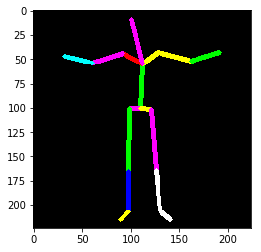

In [10]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(pose_2d, img)
plt.imshow(skltn_img[:,:,::-1])

In [286]:
pose_2d

array([[124.80448201,  99.48846452],
       [114.3481273 ,  51.45274068],
       [ 96.98604139,  45.06940761],
       [ 80.23719316,  75.75330162],
       [ 51.27935122,  89.91340841],
       [131.59725339,  38.89863897],
       [169.50062684,  60.04207741],
       [172.34490224,  30.34891439],
       [105.83934367,  10.34625184],
       [115.52792452,  99.90058521],
       [110.20177387, 170.94997993],
       [ 80.25374864, 192.13169378],
       [ 70.10224093, 215.26130274],
       [133.73209348,  99.08020453],
       [143.54300785, 162.17648013],
       [115.82939259, 210.67045747],
       [147.83779415, 213.19286231]])

In [11]:
scaled_pose = (pose_2d - 0.)*2./224. - 1.
# scaled_pose = (pose_2d[0] - 0.)*14./512.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)

In [12]:
scaled_pose.shape

(17, 2)

In [13]:
def get_limb_centers(joints_2d):

    limbs = []
    angles = []
    limb_length = []
    for i in range(1, joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        limbs.append([(x_pair[0]+x_pair[1])/2., (y_pair[0]+y_pair[1])/2.])
        limb_length.append(np.sqrt((x_pair[0]-x_pair[1])**2 + (y_pair[0]-y_pair[1])**2))
        # calculate slope, m = tan(theta)
        angles.append([(x_pair[0]-x_pair[1]), (y_pair[0]-y_pair[1])]) # because y is represented as x
    angles = np.array(angles)
    print (angles.shape)
    angles = np.arctan2(angles[:,0],angles[:,1]+1e-7)
    limbs = np.array(limbs)
    limb_length = np.array(limb_length)
    return limbs, angles, limb_length

In [14]:
limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)

(16, 2)


In [15]:
limb_centers_yx.shape

(16, 2)

In [16]:
limb_centers_yx

array([[-0.30045474, -0.00588654],
       [-0.55507716, -0.08538771],
       [-0.55673105, -0.31053483],
       [-0.54193697, -0.58073574],
       [-0.55925982,  0.07509913],
       [-0.57089932,  0.29993994],
       [-0.57151058,  0.58212264],
       [-0.71130772, -0.04757713],
       [-0.09400268, -0.06362598],
       [ 0.19041898, -0.1192096 ],
       [ 0.66335033, -0.12133737],
       [ 0.88615764, -0.15862629],
       [-0.09029808,  0.03643552],
       [ 0.19150554,  0.10889941],
       [ 0.65613677,  0.14917007],
       [ 0.88324644,  0.21410741]])

In [17]:
angles.shape

(16,)

In [18]:
limb_length

array([0.41698291, 0.19767678, 0.28971421, 0.27141529, 0.17773607,
       0.31315529, 0.27264346, 0.41695291, 0.09988346, 0.57274025,
       0.37330255, 0.10913328, 0.10037672, 0.56175701, 0.37102336,
       0.12665413])

In [18]:
eli_map1 = get_ellipse_maps(np.expand_dims(limb_centers_yx,0), [112,112], 4., 2., angles, mode='rot')

NameError: name 'get_ellipse_maps' is not defined

In [19]:
eli_map1.shape

NameError: name 'eli_map1' is not defined

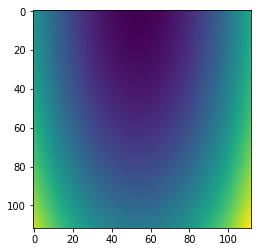

In [21]:
plt.imshow(eli_map1[0,:,:,10])

In [ ]:
## plt.imshow((eli_map1[0,:,:,16]>0.)*1. )

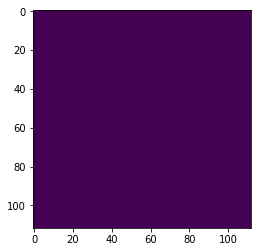

In [164]:
plt.imshow((eli_map1[0,:,:,13]>0.)*1. )

In [24]:
gauss_map1, gauss_map2 = get_gaussian_maps(np.expand_dims(map_pose,0), [14,14], 10., mode='rot')

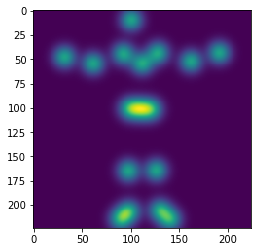

In [22]:
plt.imshow(np.sum(gauss_map1[0,:,:,:],2))

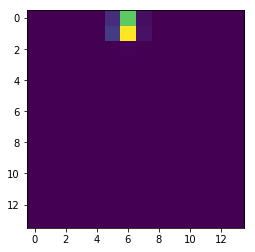

In [67]:
plt.imshow(gauss_map1[0,:,:,8])

In [49]:
limb_gauss_map1, limb_gauss_map2 = get_gaussian_maps(np.expand_dims(limb_centers_yx,0), [112,112], 2., mode='rot')

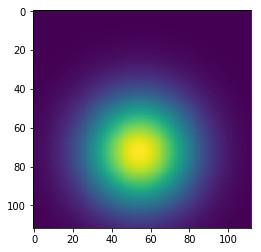

In [50]:
plt.imshow(limb_gauss_map1[0,:,:,16])

In [41]:
rot_gauss_map1 = get_rot_gaussian_maps(np.expand_dims(limb_centers_yx,0), [112,112], 2., 2., angles, mode='rot')

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[  6.12323400e-17   6.12323400e-17   6.12323400e-17   6.12323400e-17
   6.12323400e-17   6.12323400e-17   6.12323400e-17   6.12323400e-17
   6.12323400e-17   6.12323400e-17   6.12323400e-17   6.12323400e-17
   6.12323400e-17   6.12323400e-17   6.12323400e-17   6.12323400e-17
   6.12323400e-17]
(1, 17, 112, 112)


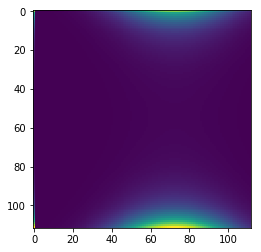

In [45]:
plt.imshow(rot_gauss_map1[0,:,:,16])

In [295]:
gauss_map1_ = get_gaussian_maps_(limb_centers_yx, [224,224], 10., 10., angles, mode='rot')

(16, 224, 224)
(16, 224, 224)
(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


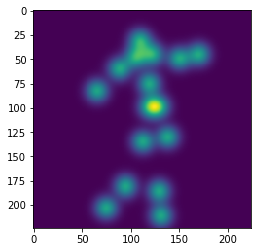

In [296]:
plt.imshow(np.sum(gauss_map1_[:,:,:],2))

In [402]:
length_ratios = np.array([15., 80., 30., 30., 80., 30., 30., 25.,
                          150., 10., 20., 110., 150., 10., 20., 40.])
width_ratios = np.array([9.5, 28., 28., 28., 28., 28., 28., 14., 28., 14., 21., 28., 28., 14., 21., 28.])
rot_gauss_map1_ = get_rot_gaussian_maps_(limb_centers_yx, [224,224], width_ratios * 1., 
                                         limb_length * length_ratios, angles, mode='rot')

In [26]:
# decreasing the value of ratio increases the length of the gaussian
length_ratios1 = np.array([2., 3., 2., 2.5, 3., 2., 2.5, 3.,
                          1.25, 2.5, 2.5, 1.75, 1.25, 2.5, 2.5, 1.75])
length_ratios = np.ones_like(length_ratios1)*2.
# decreasing the value of ratio increases the width of the gaussian
width_ratios = np.array([8., 25., 20., 25., 25., 20., 25., 12.,
                          20., 15., 20., 20., 20., 15., 20., 20.])

In [51]:
rot_gauss_map1_ = get_rot_gaussian_maps_(limb_centers_yx, [224,224], width_ratios,
                                         length_ratios / limb_length, angles, mode='rot')

(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


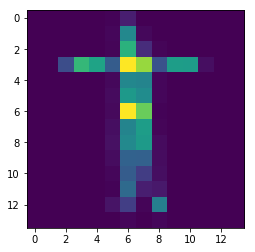

In [31]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

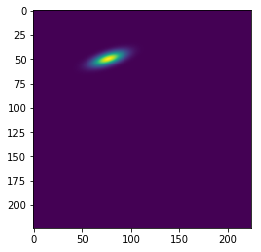

In [59]:
plt.imshow(rot_gauss_map1_[:,:,2])

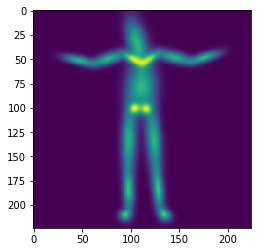

In [820]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

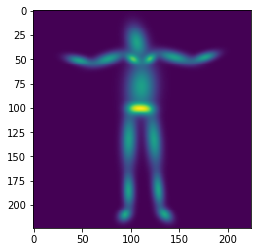

In [823]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

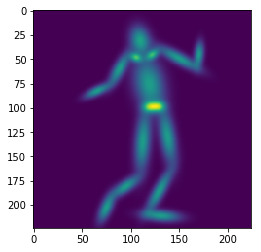

In [762]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

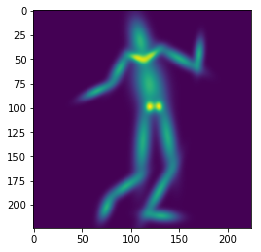

In [836]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

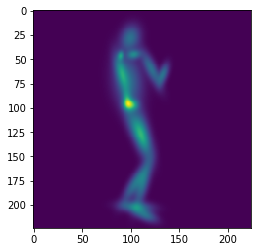

In [858]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

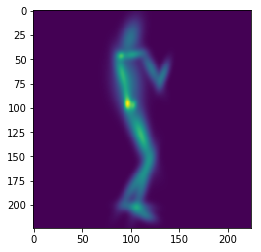

In [854]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

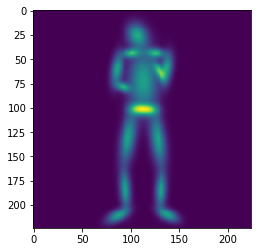

In [783]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

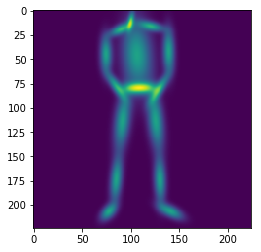

In [793]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

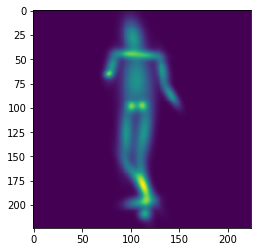

In [809]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

In [29]:
gauss_map1[0,2:8,2:8,0]

array([[6.88604186e-31, 5.01677601e-25, 3.21401497e-21, 1.81066962e-19,
        8.97012851e-20, 3.90774529e-22],
       [3.61997731e-23, 2.63730830e-17, 1.68960072e-13, 9.51865100e-12,
        4.71557715e-12, 2.05429325e-14],
       [1.67344010e-17, 1.21917268e-11, 7.81067215e-08, 4.40027407e-06,
        2.17991308e-06, 9.49656974e-09],
       [6.80272050e-14, 4.95607283e-08, 3.17512527e-04, 1.78876045e-02,
        8.86158962e-03, 3.86046143e-05],
       [2.43177404e-12, 1.77165139e-06, 1.13501462e-02, 6.39429653e-01,
        3.16775965e-01, 1.38000229e-03],
       [7.64419820e-13, 5.56912533e-07, 3.56787948e-03, 2.01002516e-01,
        9.95774373e-02, 4.33798983e-04]])

In [384]:
rot_ellipse_map1_ = get_ellipse_maps_(limb_centers_yx, [224,224], width_ratios * 1., 
                                         length_ratios * limb_length, angles, mode='rot')

(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


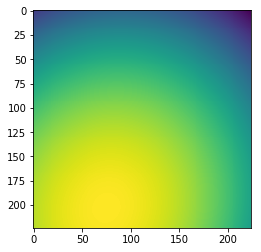

In [385]:
plt.imshow(rot_ellipse_map1_[:,:,11])

In [329]:
def apply_std(gauss_map, stds):

    # temp = np.transpose(gauss_map, [1, 2, 0, 3])

    # temp = temp.reshape()
    # print gauss_map.shape (2*161*224*1, 2*161*1*224)
    kk = np.transpose(gauss_map, [2, 3, 0, 1])*stds
    return np.transpose(kk, [2, 3, 0, 1])

def get_gaussian_maps(mu, shape_hw, inv_std, mode='ankush', inv_std_y=None):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
    


    mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]

    y = np.linspace(-1.0, 1.0, shape_hw[0])

    x = np.linspace(-1.0, 1.0, shape_hw[1])

    if mode in ['rot', 'flat']:
        mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)

        y = np.reshape(y, [1, 1, shape_hw[0], 1])
        x = np.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = (y - mu_y)**2
        g_x = (x - mu_x)**2
        # print g_y.shape, inv_std.shape, g_x.shape
        # if inv_std_y is None:
        #     dist = (g_y + g_x) 
        #     # print dist.shape
        #     dist = apply_std(dist, inv_std**2)
        #     # print dist.shape
        # else:
        dist_g_y = apply_std(g_y, inv_std**2)
        dist_g_x = apply_std(g_x, inv_std_y**2)
        dist = dist_g_y + dist_g_x

        # dist1 = (g_y + g_x) * (inv_std*4)**2

        if mode == 'rot':
            g_yx = np.exp(-dist)
            # g_yx1 = np.exp(-dist1)
        else:
            g_yx = np.exp(-tf.pow(dist + 1e-5, 0.25))

    elif mode == 'ankush':
        y = np.reshape(y, [1, 1, shape_hw[0]])
        x = np.reshape(x, [1, 1, shape_hw[1]])

        g_y = np.exp(-np.sqrt(1e-4 + np.abs((mu_y - y) * inv_std)))
        g_x = np.exp(-np.sqrt(1e-4 + np.abs((mu_x - x) * inv_std)))

        g_y = np.expand_dims(g_y, axis=3)
        g_x = np.expand_dims(g_x, axis=2)
        g_yx = np.matmul(g_y, g_x)  # [B, NMAPS, H, W]

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    g_yx = np.transpose(g_yx, [0, 2, 3, 1])

    return g_yx


In [28]:
np.stack([np.ones((17,2)), np.zeros((17,2))],2)[0,0]

array([1., 0.])

In [4]:
y = list(np.linspace(-1.0, 1.0, 14)) * 14
#     x = list(np.linspace(-1.0, 1.0, shape_hw[1])) * shape_hw[1]
    
#     y = np.array(y).reshape((shape_hw[0], shape_hw[0]))

In [7]:
y = np.array(y).reshape((14, 14))

In [8]:
y.shape

(14, 14)

In [9]:
y

array([[-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69

In [10]:
y.T

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        ],
       [-0.84615385, -0.84615385, -0.84615385, -0.84615385, -0.84615385,
        -0.84615385, -0.84615385, -0.84615385, -0.84615385, -0.84615385,
        -0.84615385, -0.84615385, -0.84615385, -0.84615385],
       [-0.69230769, -0.69230769, -0.69230769, -0.69230769, -0.69230769,
        -0.69230769, -0.69230769, -0.69230769, -0.69230769, -0.69230769,
        -0.69230769, -0.69230769, -0.69230769, -0.69230769],
       [-0.53846154, -0.53846154, -0.53846154, -0.53846154, -0.53846154,
        -0.53846154, -0.53846154, -0.53846154, -0.53846154, -0.53846154,
        -0.53846154, -0.53846154, -0.53846154, -0.53846154],
       [-0.38461538, -0.38461538, -0.38461538, -0.38461538, -0.38461538,
        -0.38461538, -0.38461538, -0.38461538, -0.38461538, -0.38461538,
        -0.38461538, -0.38

In [26]:
temp = np.tile(y, (17, 1, 1))

In [27]:
temp.shape

(17, 14, 14)

In [32]:
yx_stacked = np.stack([temp.reshape((17,-1)), temp.reshape((17,-1))], 1)

In [33]:
yx_stacked.shape

(17, 2, 196)

In [29]:
temp.reshape((17,-1)).shape

(17, 196)

In [42]:
y = []
x = []
for i in range(14):
    y.append(np.linspace(-1.0, 1.0, 14))
    x.append(np.linspace(-1.0, 1.0, 14))
y = np.stack(y, 0)
x = np.stack(x, 0).T
y = np.expand_dims(y, 0)
for i in range(16):
    y = np.concatenate([y, y[0:1]],0)
    x = np.concatenate([x, x[0:1]],0)

In [43]:
y.shape

(17, 14, 14)

In [37]:
x

array([[-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ],
       [-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69

In [11]:
def get_crop_params(target_file_name):
    # crop_params_ = 12 i.e. ends at 11 index
    try:
        crop_params = target_file_name[12:]
        params = crop_params.split('_')
        # print ("target_file_name, params ", target_file_name, params)
        # y_min, y_max, x_min, x_max = int(params[0]), int(params[1]), int(params[2]), int(params[3])
        x_min, x_max, y_min, y_max = int(params[0]), int(params[1]), int(params[2]), int(params[3])
        frame_no = int(params[4].split('.')[0])
        # print ("target_file_name ", target_file_name)
        # print ("y_min, y_max, x_min, x_max ", y_min, y_max, x_min, x_max)
    except Exception as e:
        print ("e in get_crop_params ", e)
    return y_min, y_max, x_min, x_max# , frame_no

In [418]:
mads_datapath = '/data/vcl/sid/mads_parsed/parsed_data/center_crops'
mads_datapath_dirs = os.listdir(mads_datapath)
print ("mads_datapath_dirs ", len(mads_datapath_dirs))
mads_datapath_dirs.sort()
madsbg_datapath = '/data/vcl/sid/mads_parsed/parsed_data/bkg_image'
madsbg_datapath_dirs = os.listdir(madsbg_datapath)
madsbg_datapath_dirs.sort()
madscrop_datapath = '/data/vcl/sid/mads_parsed/parsed_data/cropped_frames'
mads_posepath_2d = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d'

def _read_py_function1():

    while True:
        try:

            datapath = mads_datapath
            bg_datapath = madsbg_datapath
            folder_idx = np.random.randint(len(mads_datapath_dirs))
            folder = mads_datapath_dirs[folder_idx]
            subject_id = folder[:folder.find('_')]    # for randomly selecting another folder for taking out future frame

            num_frames = len(os.listdir(os.path.join(mads_datapath, folder)))
            frame_idx = np.random.randint(num_frames-10)    # select a random frame from this folder

            target_folder_idx = folder_idx + 2
            if target_folder_idx >= len(mads_datapath_dirs):
                target_folder_idx = folder_idx - 2
            target_subject_id = mads_datapath_dirs[target_folder_idx][:mads_datapath_dirs[target_folder_idx].find('_')]
            if target_subject_id == subject_id:
                target_folder = mads_datapath_dirs[target_folder_idx]
                num_frames = len(os.listdir(os.path.join(mads_datapath, target_folder)))
                target_frame_idx = np.random.randint(num_frames-10)

            else:
                target_folder_idx = folder_idx - 2
                target_folder = mads_datapath_dirs[target_folder_idx]
                num_frames = len(os.listdir(os.path.join(mads_datapath, target_folder)))
                target_frame_idx = np.random.randint(num_frames-10)


            file_name = os.listdir(os.path.join(datapath, folder))[frame_idx]
            source_image = cv2.imread(os.path.join(os.path.join(datapath, folder), file_name))

            target_file_name = os.listdir(os.path.join(datapath, target_folder))[target_frame_idx]
            target_image = cv2.imread(os.path.join(os.path.join(datapath, target_folder), target_file_name))

            x_min, x_max, y_min, y_max = get_crop_params(target_file_name)
            pos = target_folder.find('_video')
            bg_name = target_folder[:pos]

            background_image = cv2.imread(os.path.join(bg_datapath, bg_name+'.jpg'))
            background_image = background_image[y_min:y_max, x_min:x_max, :]

            target_index_actual = int(target_file_name.split('_')[-1].split('.')[0]) + int(target_folder.split('_')[-3])
            pose_2d = sio.loadmat(os.path.join(mads_posepath_2d, bg_name+'.mat'))['pose_2d'][target_index_actual]
            pose_2d = get_cropped_poses([384, 512], pose_2d, 224)

            label_image = target_image.copy()
            source_image = cv2.resize(source_image, (224, 224))
            target_image = cv2.resize(target_image, (224, 224)) - np.array([103.939, 116.779, 123.68])
            background_image = cv2.resize(background_image, (224, 224))
            label_image = cv2.resize(label_image, (224, 224))

            fg_mask = (1. - (label_image == background_image))*99. + 1.

            source_image = source_image[:,:,::-1].astype(np.float32) /255.0
            target_image = target_image[:,:,::-1].astype(np.float32) /255.0
            background_image = background_image[:,:,::-1].astype(np.float32) /255.0
            label_image = label_image[:,:,::-1].astype(np.float32) /255.0
            break
        except Exception as e:
            # print ("e ", e)
            continue

    return source_image, target_image, label_image, background_image, pose_2d.astype(np.float32) #, label

('mads_datapath_dirs ', 2747)


In [489]:
source_image, target_image, label_image, background_image, pose_2d_ = _read_py_function1()

[]

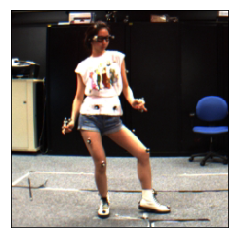

In [490]:
# fig = plt.figure()
fig,ax = plt.subplots(1)
plt.imshow(source_image)
ax.set_xticks([])
ax.set_yticks([])

[]

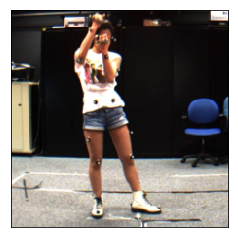

In [491]:
fig,ax = plt.subplots(1)
plt.imshow(label_image)
ax.set_xticks([])
ax.set_yticks([])

[]

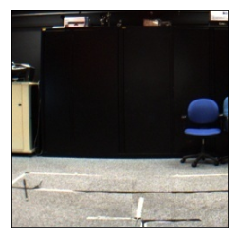

In [492]:
fig,ax = plt.subplots(1)
plt.imshow(background_image)
ax.set_xticks([])
ax.set_yticks([])

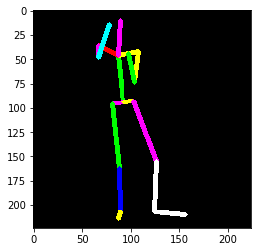

In [527]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(pose_2d, img)
plt.imshow(skltn_img[:,:,::-1])

In [497]:
pose_2d = get_cropped_poses([384, 512], pose_2d_, 224)

In [498]:
scaled_pose = (pose_2d - 0.)*2./224. - 1.
# scaled_pose = (pose_2d[0] - 0.)*14./512.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)

In [499]:
def get_limb_centers(joints_2d):

    limbs = []
    angles = []
    limb_length = []
    for i in range(1, joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        limbs.append([(x_pair[0]+x_pair[1])/2., (y_pair[0]+y_pair[1])/2.])
        limb_length.append(np.sqrt((x_pair[0]-x_pair[1])**2 + (y_pair[0]-y_pair[1])**2))
        # calculate slope, m = tan(theta)
        angles.append([(x_pair[0]-x_pair[1]), (y_pair[0]-y_pair[1])]) # because y is represented as x
    angles = np.array(angles)
    print (angles.shape)
    angles = np.arctan2(angles[:,0],angles[:,1]+1e-7)
    limbs = np.array(limbs)
    limb_length = np.array(limb_length)
    return limbs, angles, limb_length

limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)

(16, 2)


In [500]:
# decreasing the value of ratio increases the length of the gaussian
length_ratios1 = np.array([2., 3., 2., 2.5, 3., 2., 2.5, 3.,
                          1.25, 2.5, 2.5, 1.75, 1.25, 2.5, 2.5, 1.75])
length_ratios = np.ones_like(length_ratios1)*2.
# decreasing the value of ratio increases the width of the gaussian
width_ratios = np.array([8., 25., 20., 25., 25., 20., 25., 12.,
                          20., 15., 20., 20., 20., 15., 20., 20.])

In [501]:
rot_gauss_map1_ = get_rot_gaussian_maps_(limb_centers_yx, [224,224], width_ratios,
                                         length_ratios / limb_length, angles, mode='rot')

(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


In [504]:
limb_centers_yx

array([[-0.36901471, -0.196181  ],
       [-0.62872839, -0.3077274 ],
       [-0.62054276, -0.39937219],
       [-0.71910775, -0.34785649],
       [-0.60264176, -0.12207815],
       [-0.47937161, -0.04851544],
       [-0.47215033, -0.094448  ],
       [-0.74595475, -0.21054164],
       [-0.1472238 , -0.22485906],
       [ 0.1532777 , -0.24176842],
       [ 0.64836562, -0.20709831],
       [ 0.8832401 , -0.21237302],
       [-0.15816468, -0.12646931],
       [ 0.11386684,  0.02581707],
       [ 0.62046295,  0.12043452],
       [ 0.86645943,  0.25270778]])

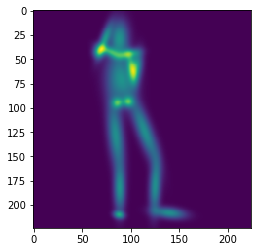

In [505]:
plt.imshow(np.sum(rot_gauss_map1_[:,:,:],2))

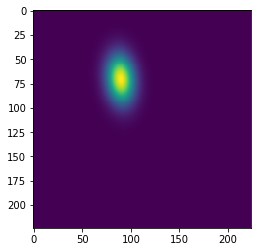

In [510]:
plt.imshow(rot_gauss_map1_[:,:,0])

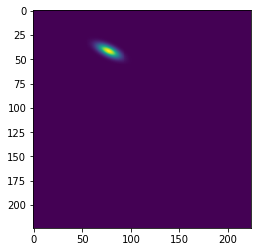

In [511]:
plt.imshow(rot_gauss_map1_[:,:,1])

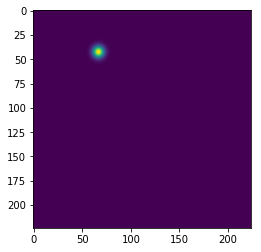

In [512]:
plt.imshow(rot_gauss_map1_[:,:,2])

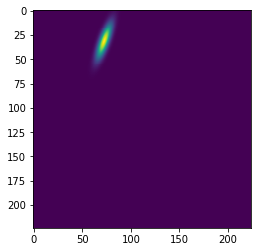

In [513]:
plt.imshow(rot_gauss_map1_[:,:,3])

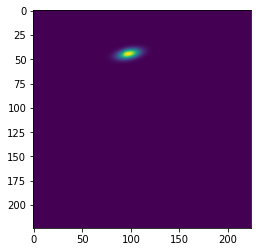

In [514]:
plt.imshow(rot_gauss_map1_[:,:,4])

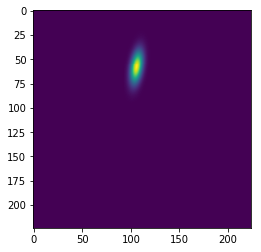

In [515]:
plt.imshow(rot_gauss_map1_[:,:,5])

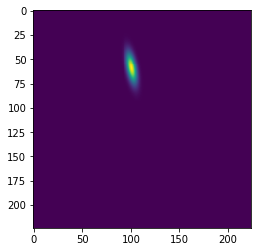

In [516]:
plt.imshow(rot_gauss_map1_[:,:,6])

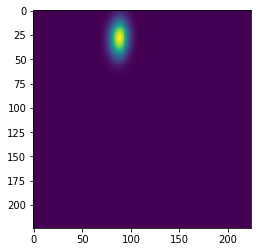

In [517]:
plt.imshow(rot_gauss_map1_[:,:,7])

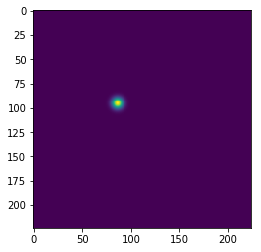

In [518]:
plt.imshow(rot_gauss_map1_[:,:,8])

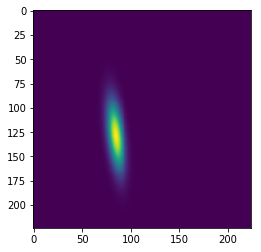

In [519]:
plt.imshow(rot_gauss_map1_[:,:,9])

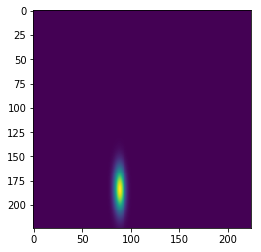

In [520]:
plt.imshow(rot_gauss_map1_[:,:,10])

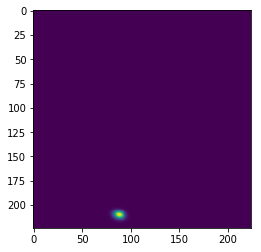

In [521]:
plt.imshow(rot_gauss_map1_[:,:,11])

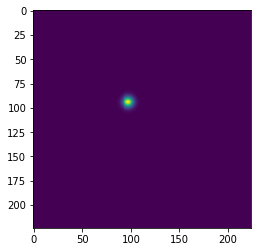

In [522]:
plt.imshow(rot_gauss_map1_[:,:,12])

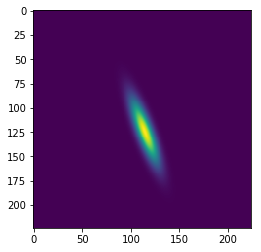

In [523]:
plt.imshow(rot_gauss_map1_[:,:,13])

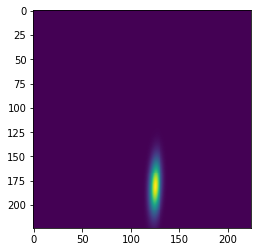

In [524]:
plt.imshow(rot_gauss_map1_[:,:,14])

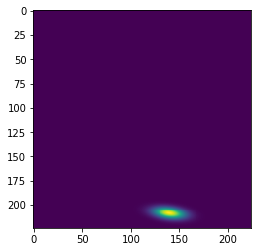

In [525]:
plt.imshow(rot_gauss_map1_[:,:,15])

In [502]:
gauss_map1_ = get_gaussian_maps_(map_pose, [224,224], 10., 10., angles, mode='rot')

(17, 224, 224)
(17, 224, 224)
(17, 224, 224)
(17, 224, 224)
(17, 224, 224)


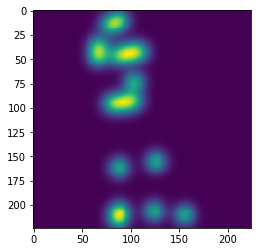

In [533]:
plt.imshow(np.sum(gauss_map1_[:,:,:],2))

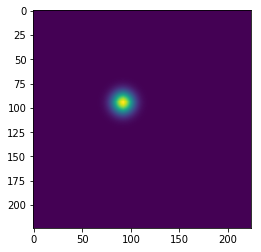

In [530]:
plt.imshow(gauss_map1_[:,:,0])

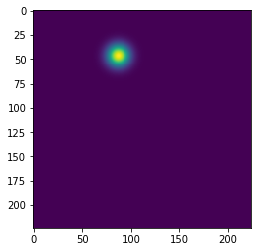

In [531]:
plt.imshow(gauss_map1_[:,:,1])

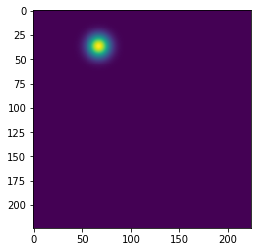

In [532]:
plt.imshow(gauss_map1_[:,:,2])

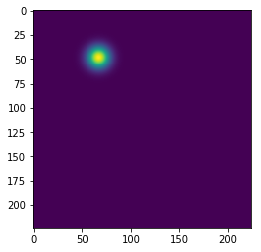

In [534]:
plt.imshow(gauss_map1_[:,:,3])

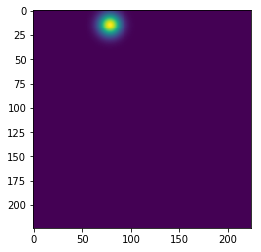

In [535]:
plt.imshow(gauss_map1_[:,:,4])

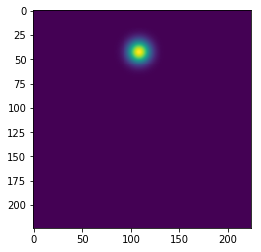

In [536]:
plt.imshow(gauss_map1_[:,:,5])

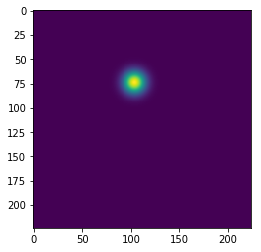

In [537]:
plt.imshow(gauss_map1_[:,:,6])

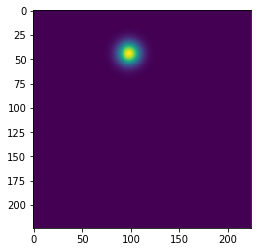

In [538]:
plt.imshow(gauss_map1_[:,:,7])

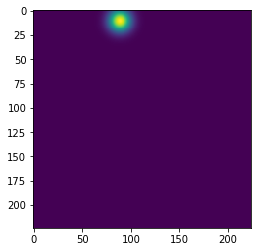

In [539]:
plt.imshow(gauss_map1_[:,:,8])

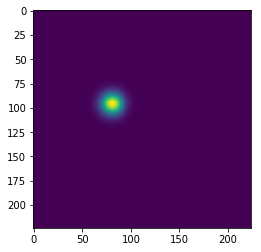

In [540]:
plt.imshow(gauss_map1_[:,:,9])

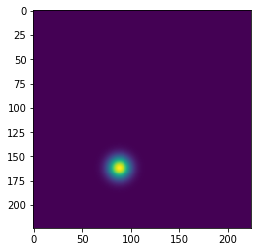

In [541]:
plt.imshow(gauss_map1_[:,:,10])

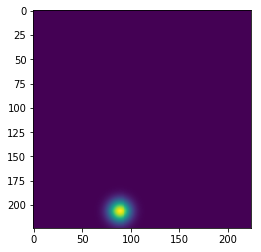

In [542]:
plt.imshow(gauss_map1_[:,:,11])

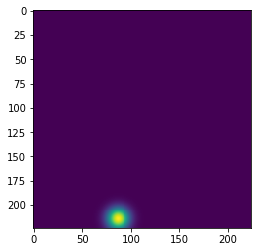

In [543]:
plt.imshow(gauss_map1_[:,:,12])

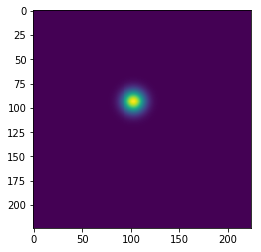

In [544]:
plt.imshow(gauss_map1_[:,:,13])

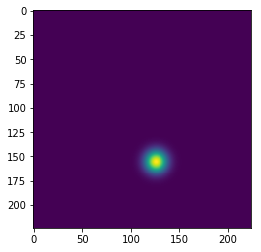

In [545]:
plt.imshow(gauss_map1_[:,:,14])

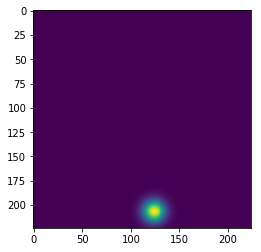

In [546]:
plt.imshow(gauss_map1_[:,:,15])

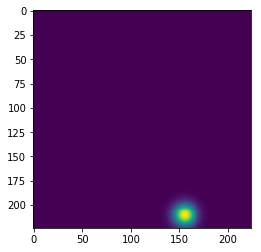

In [548]:
plt.imshow(gauss_map1_[:,:,16])

In [354]:
pose_2d

array([[120.60907 ,  97.05292 ],
       [118.61379 ,  30.034061],
       [121.19442 ,  37.833824],
       [112.67623 ,  65.81467 ],
       [ 89.63179 ,  84.02509 ],
       [118.89775 ,  39.491703],
       [121.43847 ,  76.95156 ],
       [108.271385, 110.55781 ],
       [114.05181 ,   7.311332],
       [126.35555 ,  95.526215],
       [117.91268 , 153.97629 ],
       [135.38165 , 206.86006 ],
       [114.641624, 209.82805 ],
       [114.60392 ,  98.649315],
       [113.10861 , 159.25214 ],
       [126.67255 , 215.96188 ],
       [ 95.298706, 217.50182 ]], dtype=float32)

In [34]:
def get_rot_gaussian_maps(mu, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]     # (B, 17, 1)

    y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

    x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))  # Bx14
        
    y = tf.reshape(tf.tile(y, [shape_hw[0]]), (-1, shape_hw[0], shape_hw[0]))
    y = tf.expand_dims(y,0) * tf.ones((mu.shape[1], shape_hw[0], shape_hw[0]))
    
    x = tf.reshape(tf.tile(x, [shape_hw[1]]), (-1, shape_hw[1], shape_hw[1]))  # Bx14x14
    x = tf.expand_dims(x,0) * tf.ones((mu.shape[1], shape_hw[1], shape_hw[1]))  # Bx16x14x14
    x = tf.transpose(x, perm=[0,1,3,2])
    mu_y, mu_x = tf.expand_dims(mu_y, 3), tf.expand_dims(mu_x, 3) # Bx16x1x1
    
    y = y - mu_y
    x = x - mu_x  # Bx16x14x14
    print ("y ", y)
    print ("x ", x)
    
    if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
        yx_stacked = tf.stack([tf.reshape(y,(-1, y.shape[1],y.shape[2]*y.shape[3])), 
                               tf.reshape(x,(-1, x.shape[1],x.shape[2]*x.shape[3]))], 2)   # (B, 16, 2, 196)
        rot_mat = tf.stack([ tf.stack([tf.cos(angles), tf.sin(angles)],2), 
                             tf.stack([-tf.sin(angles), tf.cos(angles)],2) ], 3)   # (B, 16, 2, 2)

        rotated = tf.matmul(rot_mat, yx_stacked)   # (B, 16, 2, 196)
        
        y_rot = rotated[:,:,0,:]   # (B, 16, 196)
        x_rot = rotated[:,:,1,:]   # (B, 16, 196)
                
        y_rot = tf.reshape(y_rot, (-1, mu.shape[1],shape_hw[0],shape_hw[0]))   # (B, 16, 14, 14)
        x_rot = tf.reshape(x_rot, (-1, mu.shape[1],shape_hw[1],shape_hw[1]))   # (B, 16, 14, 14)


        g_y = tf.square(y_rot)   # (B, 16, 14, 14)
        g_x = tf.square(x_rot)   # (B, 16, 14, 14)

        inv_std1 = tf.expand_dims(tf.expand_dims(inv_std1, 2), 2) # Bx16x1x1
        inv_std2 = tf.expand_dims(tf.expand_dims(inv_std2, 2), 2) # Bx16x1x1
        dist = (g_y * inv_std1**2 + g_x * tf.to_float(inv_std2)**2)

        if mode == 'rot':
            g_yx = tf.exp(-dist)

        else:
            g_yx = tf.exp(-tf.pow(dist + 1e-5, 0.25))

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    print (g_yx)
    g_yx = tf.transpose(g_yx, perm=[0, 3, 2, 1])

    return g_yx

In [17]:
def get_limb_centers(joints_2d):

    limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]

    angles_x = []
    angles_y = []
    limbs_x = []
    limbs_y = []
    limb_length = []
    for i in range(1, joints_2d.shape[1]):
        x_pair = [joints_2d[:, i, 0], joints_2d[:, limb_parents[i], 0]]
        y_pair = [joints_2d[:, i, 1], joints_2d[:, limb_parents[i], 1]]

        limbs_x.append((x_pair[0]+x_pair[1])/2.)
        limbs_y.append((y_pair[0]+y_pair[1])/2.)
        limb_length.append(tf.sqrt((x_pair[0]-x_pair[1])**2 + (y_pair[0]-y_pair[1])**2))

        angles_x.append(x_pair[0]-x_pair[1]) # because y is represented as x
        angles_y.append(y_pair[0]-y_pair[1])

    angles_x = tf.stack(angles_x, 1)
    angles_y = tf.stack(angles_y, 1)

    angles = tf.atan2(angles_x, angles_y+1e-7)       # x/y as pose is passed as (y,x)
    
    limbs_x = tf.stack(limbs_x, 1)
    limbs_y = tf.stack(limbs_y, 1)

    limbs = tf.stack([limbs_x, limbs_y], 2)
    limb_length = tf.stack(limb_length, 1)

    return limbs, angles, limb_length

In [19]:
import tensorflow as tf

In [35]:
batch_size = 1
n_limbs = 12

pose_points = tf.placeholder(tf.float32, shape=(1,17, 2), name='joints')

points_exchanged = tf.stack([pose_points[:,:,1], pose_points[:,:,0]], 2, name='points_exchanged')/112. - 1.
limbs, angles, limb_length = get_limb_centers(points_exchanged)
length_ratios = tf.ones(17-1)*2.
width_ratios = tf.constant([8., 25., 20., 25., 25., 20., 25., 12.,
                          20., 15., 20., 20., 20., 15., 20., 20.])*tf.ones_like(limb_length)
limb_map = get_rot_gaussian_maps(limbs, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')
with tf.Session() as sess:
    limb_gauss_map = sess.run([limb_map], feed_dict={pose_points: np.expand_dims(pose_2d,0)})

('y ', <tf.Tensor 'sub_386:0' shape=(1, 16, 224, 224) dtype=float32>)
('x ', <tf.Tensor 'sub_387:0' shape=(1, 16, 224, 224) dtype=float32>)
Tensor("Exp_2:0", shape=(1, 16, 224, 224), dtype=float32)


In [14]:
pose_2d

array([[100.46611489,  97.28156355],
       [ 94.35242665,  46.87259289],
       [ 85.49755821,  45.47078988],
       [ 95.2219646 ,  81.07977021],
       [ 99.09455041, 105.70685523],
       [113.48185025,  43.41231531],
       [130.08321687,  78.26167796],
       [138.73224165,  52.61351302],
       [105.67557311,   9.61864011],
       [ 93.85393648,  96.53380567],
       [120.68226203, 152.37611742],
       [104.93874305, 206.75058341],
       [125.15487458, 215.68241967],
       [106.77405889,  97.98813603],
       [118.09272993, 155.64993745],
       [ 91.06096901, 201.14149876],
       [120.6481871 , 203.40934387]])

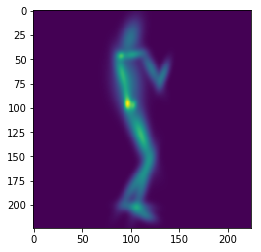

In [36]:
plt.imshow(np.sum(limb_gauss_map[0][0][:,:,:],2))

In [27]:
limb_gauss_map[0].shape

(1, 224, 224, 16)